# Introduction

- **Subjects**: 30
- **Sensors**: three-axis acceleration, three-axis gyroscope
- **Sampling**: 50Hz, 2.56s window (128 time points)
- **Statistical features**: 561 dimensions (such as mean, variance, FFT, etc.)
- **Original time series**: 9 signal files (body_acc_x/y/z, body_gyro_x/y/z, total_acc_x/y/z)

```text
UCI_HAR_Dataset/
├── README.txt
├── activity_labels.txt
├── features.txt
├── features_info.txt
├── test
│   ├── Inertial Signals
│   │   ├── body_acc_x_test.txt
│   │   ├── body_acc_y_test.txt
│   │   ├── body_acc_z_test.txt
│   │   ├── body_gyro_x_test.txt
│   │   ├── body_gyro_y_test.txt
│   │   ├── body_gyro_z_test.txt
│   │   ├── total_acc_x_test.txt
│   │   ├── total_acc_y_test.txt
│   │   └── total_acc_z_test.txt
│   ├── X_test.txt
│   ├── subject_test.txt
│   └── y_test.txt
└── train
    ├── Inertial Signals
    │   ├── body_acc_x_train.txt
    │   ├── body_acc_y_train.txt
    │   ├── body_acc_z_train.txt
    │   ├── body_gyro_x_train.txt
    │   ├── body_gyro_y_train.txt
    │   ├── body_gyro_z_train.txt
    │   ├── total_acc_x_train.txt
    │   ├── total_acc_y_train.txt
    │   └── total_acc_z_train.txt
    ├── X_train.txt
    ├── subject_train.txt
    └── y_train.txt
```

# Data preprocessing

1. Load metadata from features.txt and activity_labels.txt;

2. Read the feature matrix and labels of the training/test sets;

3. Map the label encoding to readable activity names;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# 2.1 Path configuration
data_path = '../data/UCI_HAR_Dataset/'
# 2.2 Loading metadata
features = pd.read_csv(data_path+'features.txt', header=None, sep='\s+', names=['idx','feature'])
activity_labels = pd.read_csv(data_path+'activity_labels.txt', header=None, sep='\s+', names=['id','activity'])
# 2.3 Read training/test sets
X_train = pd.read_csv(data_path+'train/X_train.txt', header=None, sep='\s+')
y_train = pd.read_csv(data_path+'train/y_train.txt', header=None, sep='\s+', names=['activity_id'])
X_test  = pd.read_csv(data_path+'test/X_test.txt',  header=None, sep='\s+')
y_test  = pd.read_csv(data_path+'test/y_test.txt',  header=None, sep='\s+', names=['activity_id'])
# 2.4 Apply feature names and clean up
clean_feat = features['feature'].str.replace('[()]','',regex=True).str.replace(',','_')
X_train.columns = clean_feat
X_test.columns  = clean_feat
# 2.5 Merge tags and names
y_train = y_train.merge(activity_labels, left_on='activity_id', right_on='id')
y_test  = y_test.merge(activity_labels,  left_on='activity_id', right_on='id')
# 2.6 Display basic information
print(f"X_train: {X_train.shape}, y_train: {y_train['activity'].value_counts().to_dict()}")

X_train: (7352, 561), y_train: {'LAYING': 1407, 'STANDING': 1374, 'SITTING': 1286, 'WALKING': 1226, 'WALKING_UPSTAIRS': 1073, 'WALKING_DOWNSTAIRS': 986}


In [3]:
# Display some column names
X_train.columns[:10]

Index(['tBodyAcc-mean-X', 'tBodyAcc-mean-Y', 'tBodyAcc-mean-Z',
       'tBodyAcc-std-X', 'tBodyAcc-std-Y', 'tBodyAcc-std-Z', 'tBodyAcc-mad-X',
       'tBodyAcc-mad-Y', 'tBodyAcc-mad-Z', 'tBodyAcc-max-X'],
      dtype='object', name='feature')

In [4]:
# Display the first few lines of labels
y_train.head(10)

,activity_id,id,activity
0,5,5,STANDING
1,5,5,STANDING
2,5,5,STANDING
3,5,5,STANDING
4,5,5,STANDING
5,5,5,STANDING
6,5,5,STANDING
7,5,5,STANDING
8,5,5,STANDING
9,5,5,STANDING


In [5]:
X_train.describe()

feature,tBodyAcc-mean-X,tBodyAcc-mean-Y,tBodyAcc-mean-Z,tBodyAcc-std-X,tBodyAcc-std-Y,tBodyAcc-std-Z,tBodyAcc-mad-X,tBodyAcc-mad-Y,tBodyAcc-mad-Z,tBodyAcc-max-X,...,fBodyBodyGyroJerkMag-meanFreq,fBodyBodyGyroJerkMag-skewness,fBodyBodyGyroJerkMag-kurtosis,angletBodyAccMean_gravity,angletBodyAccJerkMean_gravityMean,angletBodyGyroMean_gravityMean,angletBodyGyroJerkMean_gravityMean,angleX_gravityMean,angleY_gravityMean,angleZ_gravityMean
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [6]:
X_train.head()

feature,tBodyAcc-mean-X,tBodyAcc-mean-Y,tBodyAcc-mean-Z,tBodyAcc-std-X,tBodyAcc-std-Y,tBodyAcc-std-Z,tBodyAcc-mad-X,tBodyAcc-mad-Y,tBodyAcc-mad-Z,tBodyAcc-max-X,...,fBodyBodyGyroJerkMag-meanFreq,fBodyBodyGyroJerkMag-skewness,fBodyBodyGyroJerkMag-kurtosis,angletBodyAccMean_gravity,angletBodyAccJerkMean_gravityMean,angletBodyGyroMean_gravityMean,angletBodyGyroJerkMean_gravityMean,angleX_gravityMean,angleY_gravityMean,angleZ_gravityMean
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


# Exploratory Data Analysis (EDA)

## Activity Label Distribution

Count the number of samples of each activity in the training set to understand whether the data is balanced:

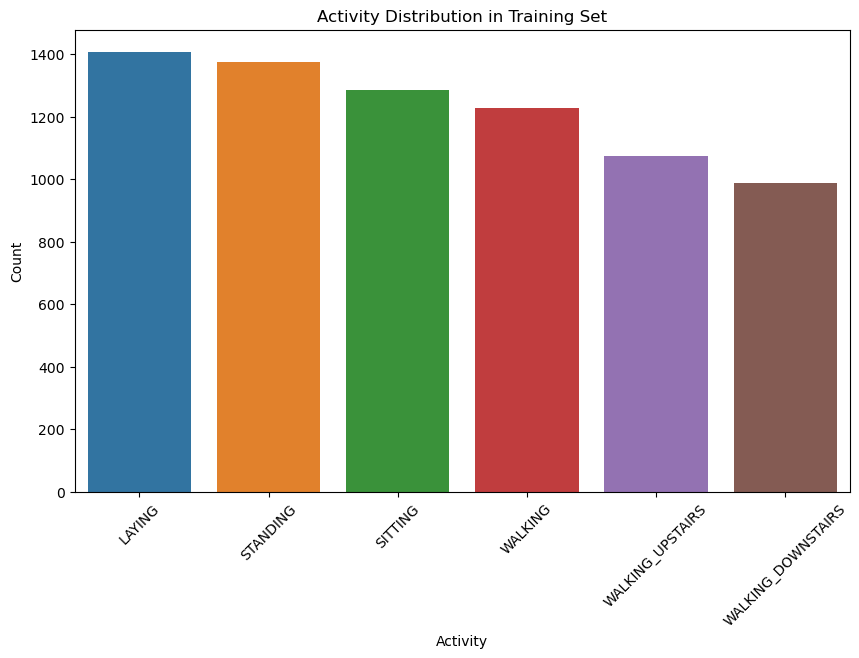

In [7]:
# Plot frequency distribution of active tags
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='activity', order=y_train['activity'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Activity Distribution in Training Set')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()


The results show that there are differences in the number of tags such as WALKING, SITTING, and LAYING, and the sampling strategy needs to be considered when modeling.

## Feature statistics and distribution

### Line plot of first 10 features

Count the number of samples of each activity in the training set to understand whether the data is balanced

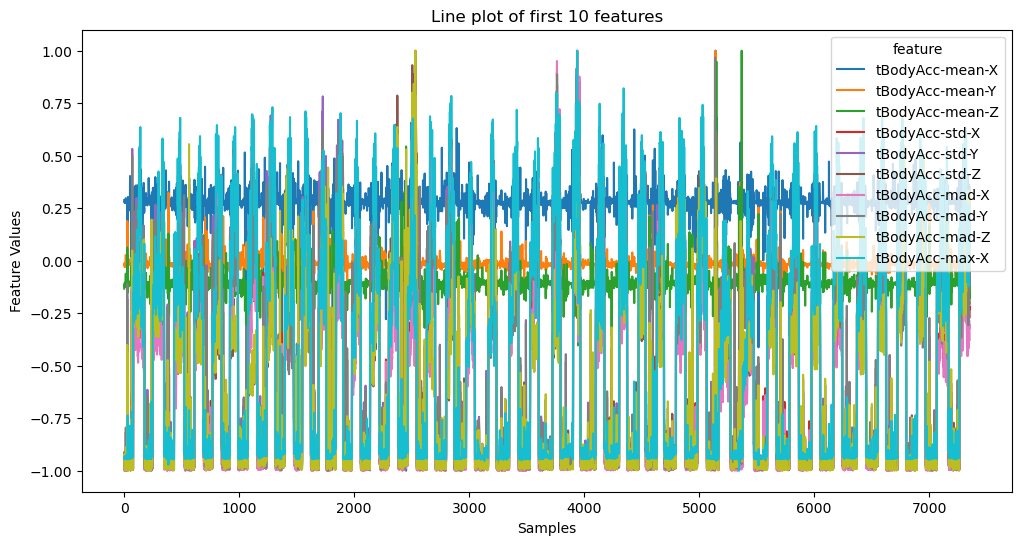

In [8]:
# Select the first 10 features for visualization
selected_columns = X_train.columns[:10]

# Visualize the distribution of these features
X_train[selected_columns].plot(kind='line', figsize=(12, 6))
plt.title('Line plot of first 10 features')
plt.xlabel('Samples')
plt.ylabel('Feature Values')
plt.show()


The sharp fluctuations in the curves of certain features may mean that these features contain large noise or correspond to certain specific dynamic changes.

### Distribution of tBodyAcc mean-X

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of tBodyAcc mean-X')

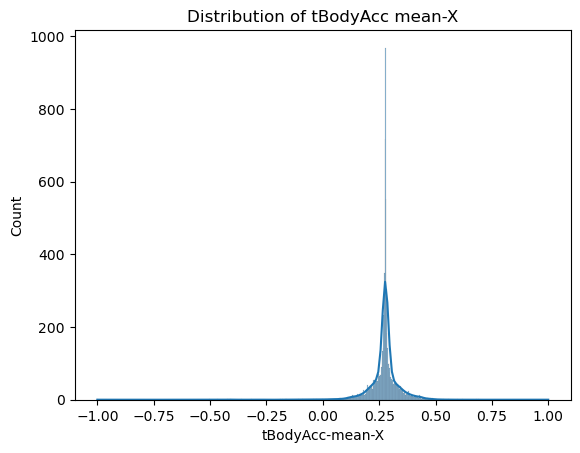

In [9]:
sns.histplot(X_train['tBodyAcc-mean-X'], kde=True)
plt.title('Distribution of tBodyAcc mean-X')

This figure shows the distribution of the tBodyAcc-mean-X feature in the training set, and further smoothes the probability density function of the feature through the kernel density estimation (KDE) curve. As can be seen from the figure, the data distribution is symmetrical and bell-shaped, which conforms to the typical form of normal distribution.

### Correlation Matrix of Features

Compute the correlations between all features in the training set and visualize these correlation matrices via heatmaps.

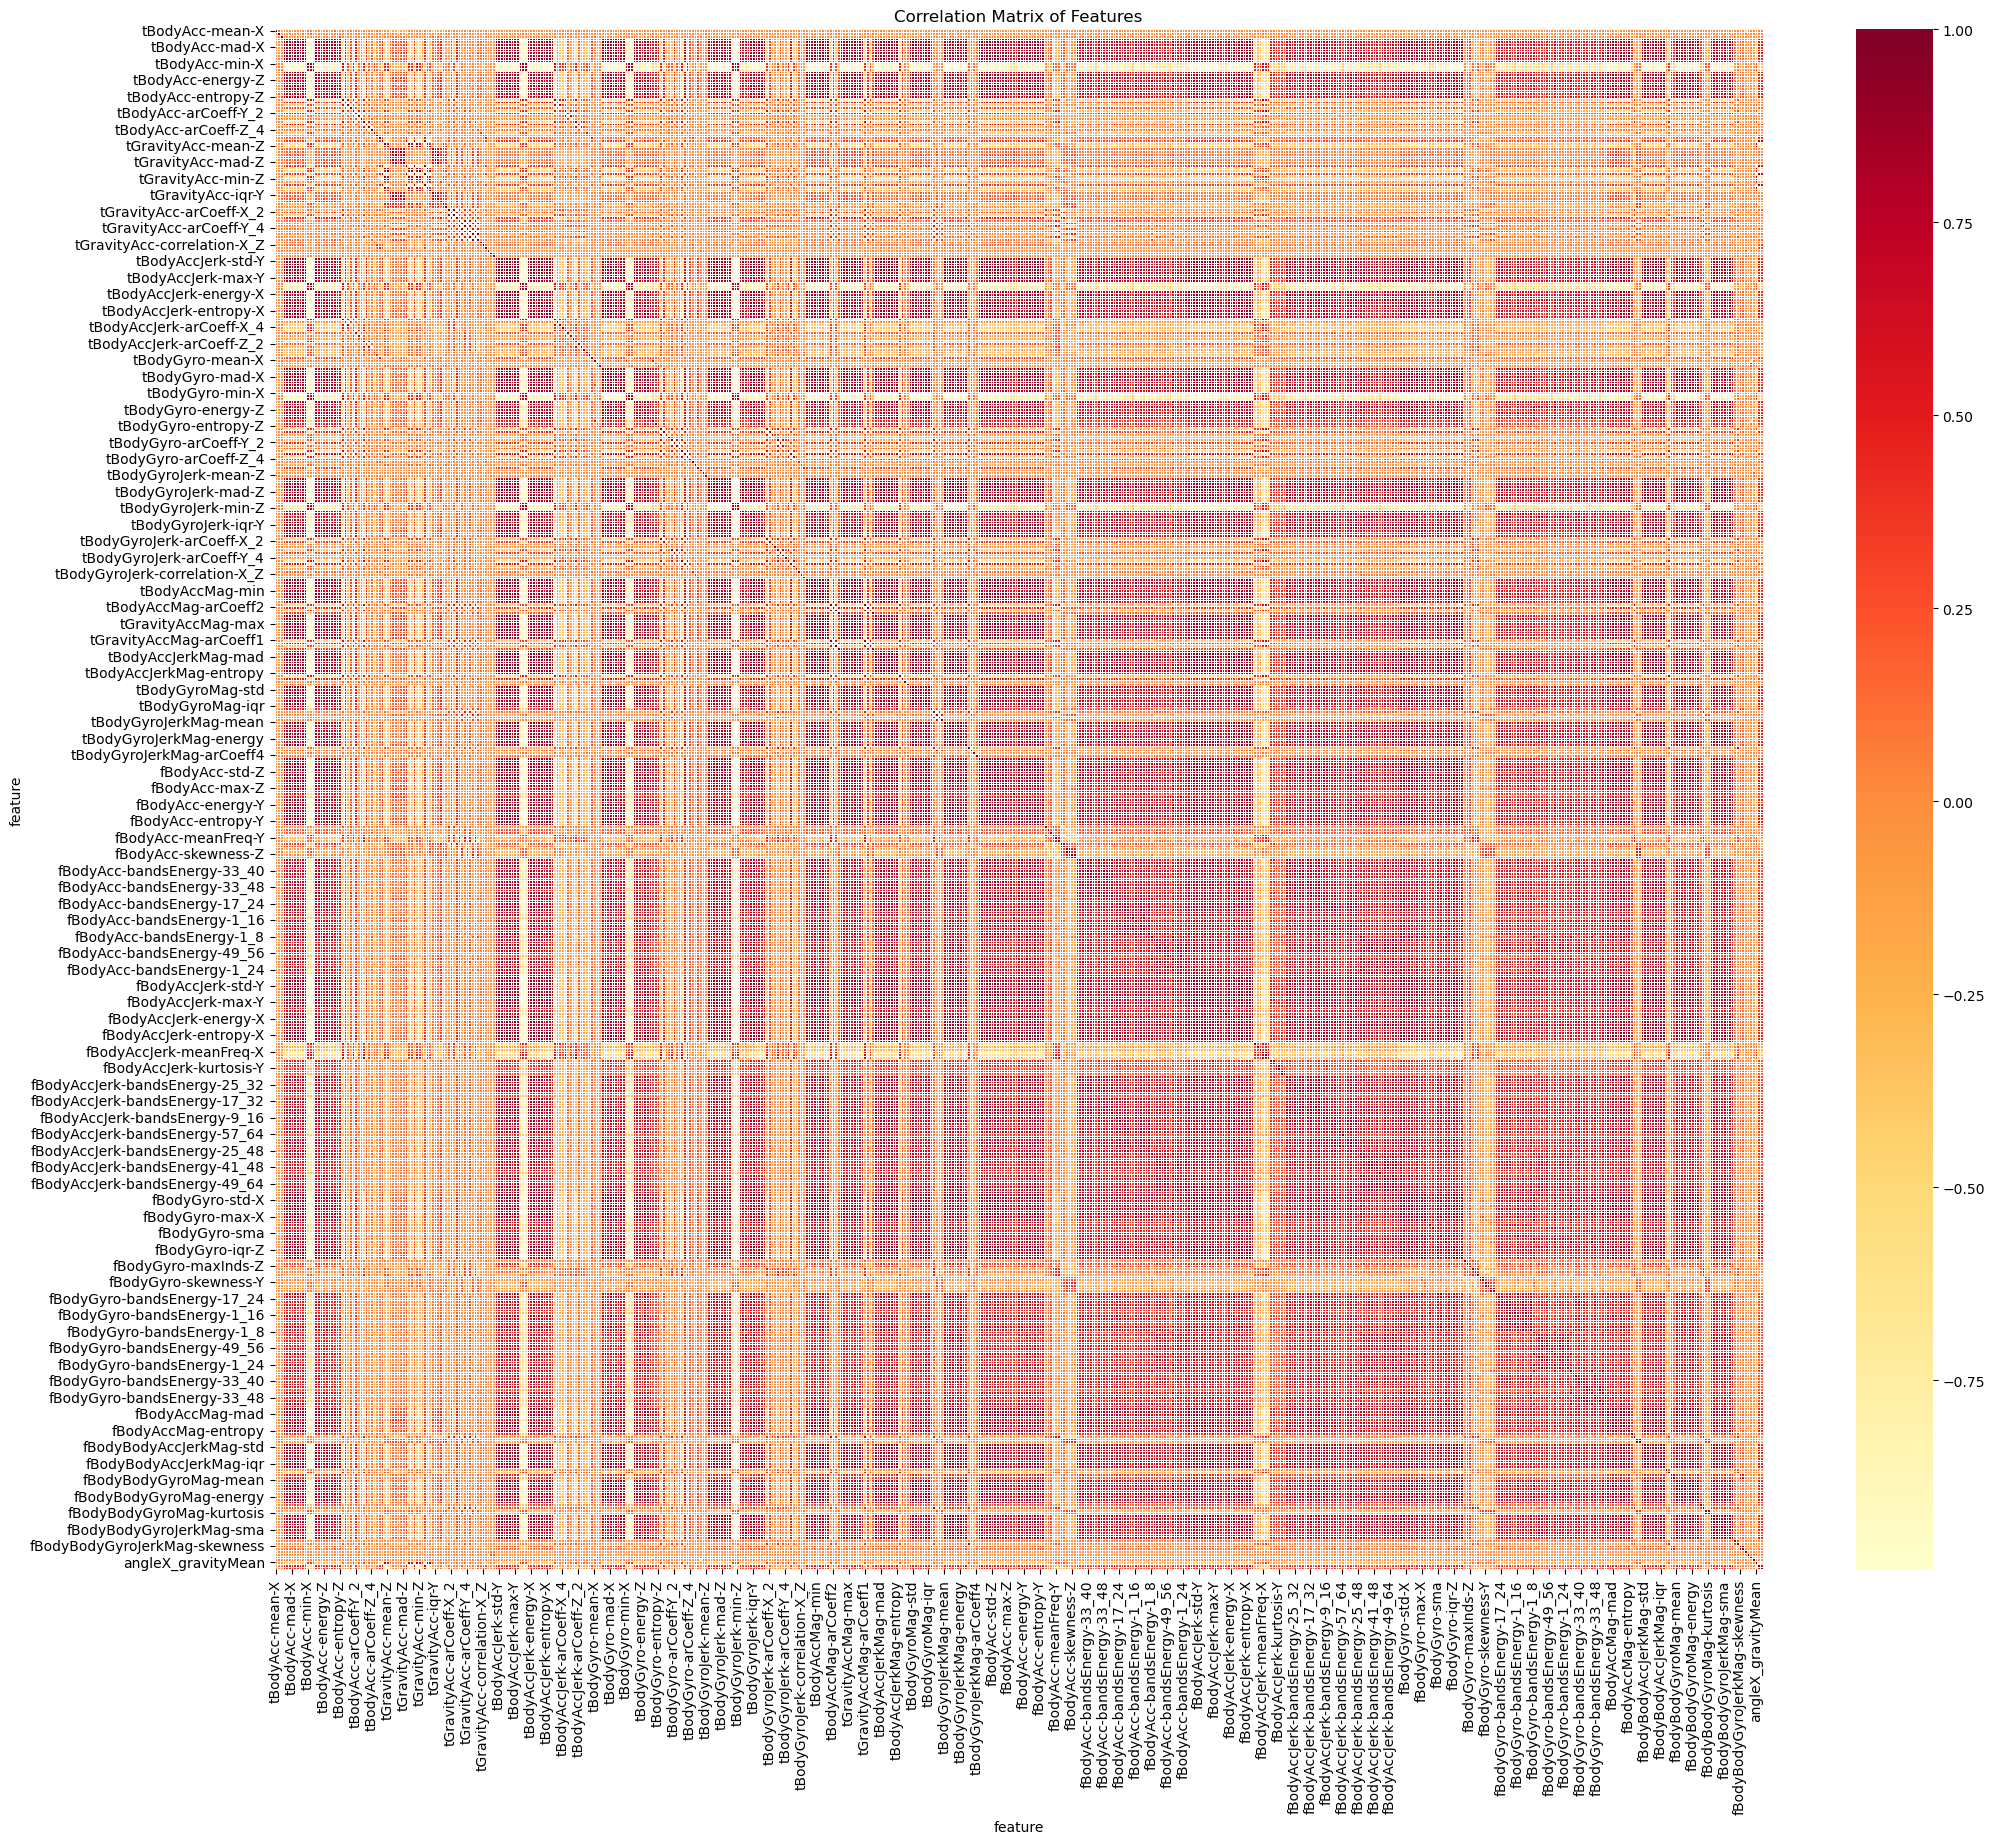

In [10]:
# Calculate the correlation between features
correlation_matrix = X_train.corr()

# Draw a heat map
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='YlOrRd', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


Text(0.5, 1.0, 'Correlation Matrix (first 50 features)')

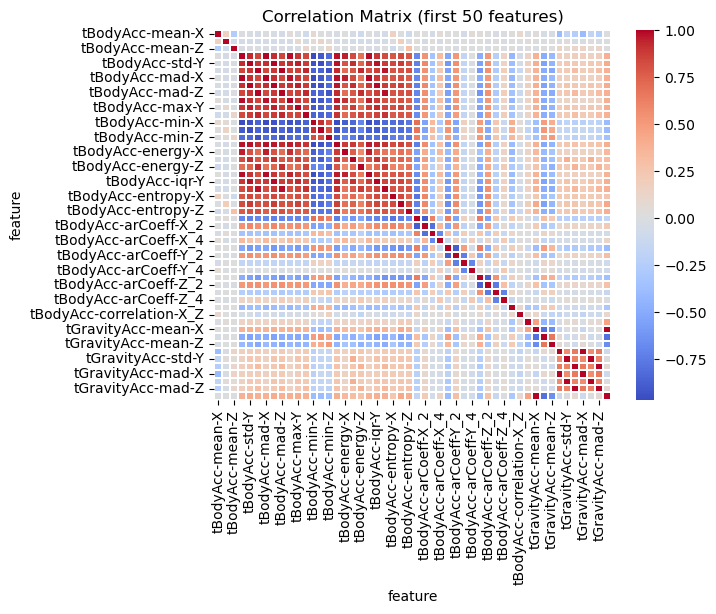

In [11]:
# Draw a heat map for the first 50 features
corr = X_train.iloc[: , :50].corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.3)
plt.title('Correlation Matrix (first 50 features)')

## Feature by Activity

The box plot shows the distribution of tBodyAcc-mean-X features in the training set under different activities.

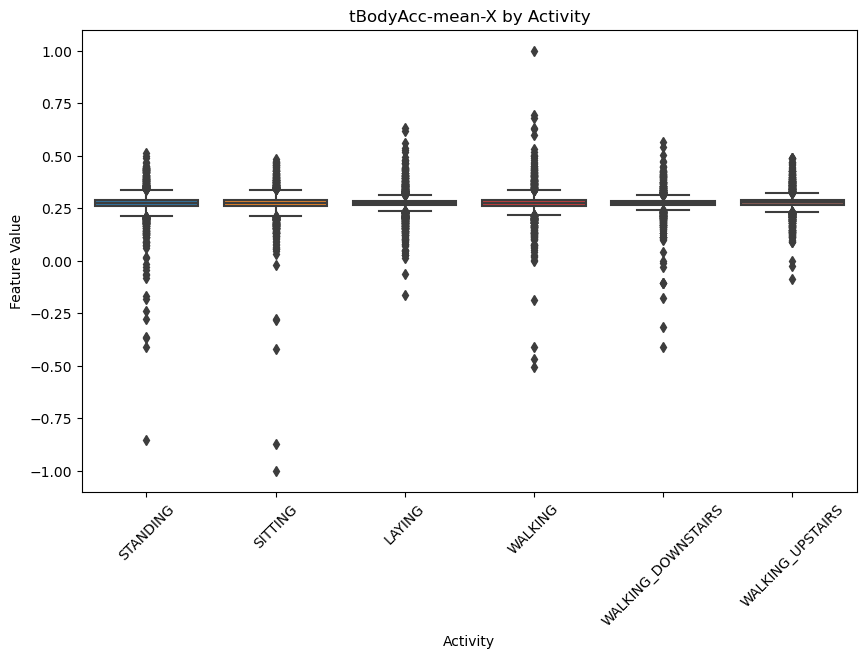

In [26]:
# Select a feature for activity comparison
feature_to_plot = 'tBodyAcc-mean-X'

plt.figure(figsize=(10, 6))
sns.boxplot(x='activity', y=feature_to_plot, data=pd.concat([X_train, y_train], axis=1))
plt.xticks(rotation=45)
plt.title(f'{feature_to_plot} by Activity')
plt.xlabel('Activity')
plt.ylabel('Feature Value')
plt.show()


From the box plot, we can see that among all the activities, there are some significant outliers (points outside the whiskers) in the STANDING, SITTING, WALKING, and WALKING_DOWNSTAIRS activities. These outliers may represent some extreme samples, such as sensor noise, motion anomalies, or human error in labeling. **We removed these outliers from the dataset**.

The number of rows in the original dataset：7352
Number of rows after removing outliers：5557


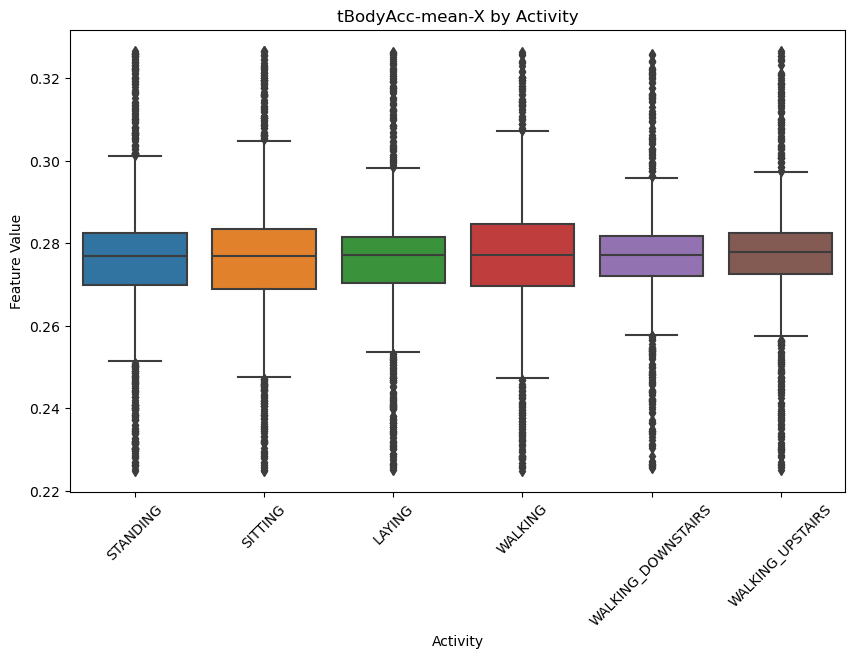

In [28]:
# Calculate IQR (interquartile range)
Q1 = X_train['tBodyAcc-mean-X'].quantile(0.25)
Q3 = X_train['tBodyAcc-mean-X'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower limits, data outside this range is an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
X_train_no_outliers = X_train[(X_train['tBodyAcc-mean-X'] >= lower_bound) & (X_train['tBodyAcc-mean-X'] <= upper_bound)]

print(f"The number of rows in the original dataset：{X_train.shape[0]}")
print(f"Number of rows after removing outliers：{X_train_no_outliers.shape[0]}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='activity', y=feature_to_plot, data=pd.concat([X_train_no_outliers, y_train], axis=1))
plt.xticks(rotation=45)
plt.title(f'{feature_to_plot} by Activity')
plt.xlabel('Activity')
plt.ylabel('Feature Value')
plt.show()

# Time Series Visualization

## Single Activity Window

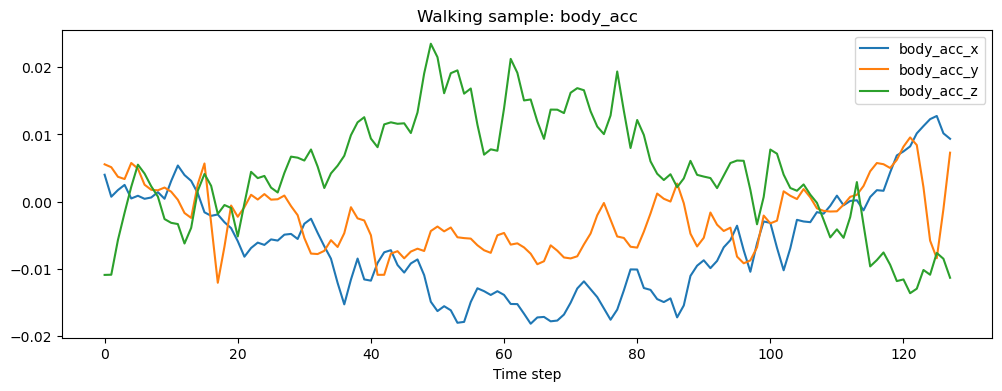

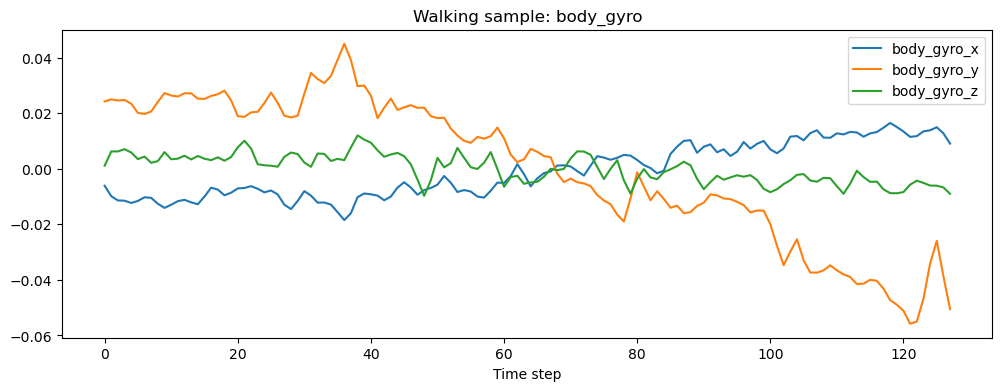

In [13]:
# 3.1.1 Loading original timing signal
signal_types = ['body_acc_x','body_acc_y','body_acc_z','body_gyro_x','body_gyro_y','body_gyro_z']
signals = {sig: pd.read_csv(f"{data_path}train/Inertial Signals/{sig}_train.txt", header=None, sep='\s+')
           for sig in signal_types}
# 3.1.2 Select the first WALKING sample
idx = y_train[y_train['activity']=='WALKING'].index[0]
t = np.arange(signals['body_acc_x'].shape[1])  # 0-127
# 3.1.3 Drawing acceleration and gyroscope
plt.figure(figsize=(12,4))
for ax in ['body_acc_x','body_acc_y','body_acc_z']:
    plt.plot(t, signals[ax].iloc[idx], label=ax)
plt.legend(); plt.title('Walking sample: body_acc'); plt.xlabel('Time step'); plt.show()

plt.figure(figsize=(12,4))
for ax in ['body_gyro_x','body_gyro_y','body_gyro_z']:
    plt.plot(t, signals[ax].iloc[idx], label=ax)
plt.legend(); plt.title('Walking sample: body_gyro'); plt.xlabel('Time step'); plt.show()

## Comparison of different activities

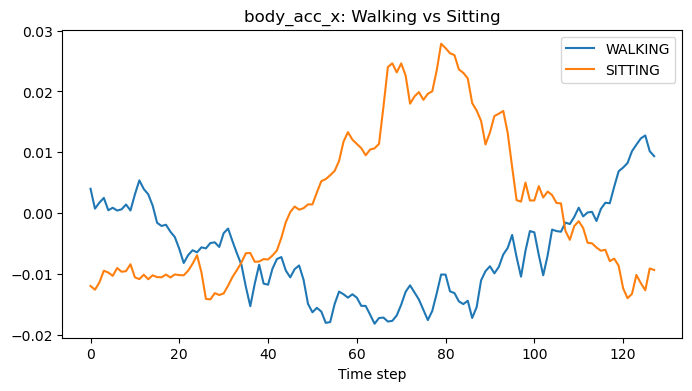

In [14]:
plt.figure(figsize=(8,4))
for act in ['WALKING','SITTING']:
    i = y_train[y_train['activity']==act].index[0]
    plt.plot(t, signals['body_acc_x'].iloc[i], label=act)
plt.legend(); plt.title('body_acc_x: Walking vs Sitting'); plt.xlabel('Time step'); plt.show()

# Feature Engineering

## Standardization

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[ 0.20064157, -0.0636826 , -0.41962845, ..., -0.68721921,
         0.40794614, -0.00756789],
       [ 0.05594788,  0.03148567, -0.25390836, ..., -0.694138  ,
         0.40911698,  0.00787517],
       [ 0.07351535, -0.04341648, -0.07629468, ..., -0.702239  ,
         0.4102883 ,  0.02650234],
       ...,
       [-0.01566765,  0.0167814 ,  1.13222107, ..., -0.56584847,
         0.64059683,  0.34870928],
       [ 0.21586648, -0.02812252, -0.86770988, ..., -0.57766781,
         0.63147758,  0.29327564],
       [ 1.09620157,  0.12919873, -1.67268082, ..., -0.57392691,
         0.63274259,  0.33396081]])

## PCA Dimensionality Reduction

In [16]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio:', pca.explained_variance_ratio_.sum())

Explained variance ratio: 0.773708780746934


## Discrete Wavelet Transform

### Define DWT feature extraction function
Perform a layer of DWT on the signal sequence of each 128-step window (for example, using Daubechies 4 wavelet), and then calculate statistics (such as mean, standard deviation, energy, etc.) for each layer of coefficients.

In [17]:
import pywt
def extract_dwt_features(signal, wavelet='db4', level=1):
    """
    Perform DWT on a one-dimensional signal and extract the statistical features of the coefficients
    signal: 1D array or pandas Series, length 128
    wavelet: wavelet name
    level: number of decomposition levels
    return: dict, keys such as 'cA_mean', 'cA_std', 'cD_mean', 'cD_std'
    """
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    features = {}
    # cA is the approximation coefficient, cD is the detail coefficient
    labels = ['A', 'D']
    for i, c in enumerate(coeffs):
        label = labels[i] if i < 2 else f"D{i}"
        features[f'c{label}_mean'] = np.mean(c)
        features[f'c{label}_std']  = np.std(c)
        features[f'c{label}_energy'] = np.sum(c**2)
    return features


### Extract DWT features from selected feature columns in batches

Take `tBodyAcc-mean()-X` as an example to extract DWT features from all windows in the training set. You can also extend it to multiple axes or multiple raw signals.

In [18]:
# New DWT feature extraction loop:
dwt_features_list = []
for idx in range(len(signals['body_acc_x'])):
    # Select the idxth window of body_acc_x
    sig = signals['body_acc_x'].iloc[idx].values
    feats = extract_dwt_features(sig, wavelet='db4', level=1)
    feats['activity']   = y_train.loc[idx, 'activity']
    feats['window_idx'] = idx
    dwt_features_list.append(feats)

# Convert to DataFrame
df_dwt = pd.DataFrame(dwt_features_list)
print("DWT feature table shape:", df_dwt.shape)
df_dwt.head()

DWT feature table shape: (7352, 8)


,cA_mean,cA_std,cA_energy,cD_mean,cD_std,cD_energy,activity,window_idx
0,0.003472,0.004193,0.001986,0.000015,0.001138,0.000087,STANDING,0
1,0.000392,0.002685,0.000493,-0.000006,0.000942,0.000059,STANDING,1
2,0.000517,0.004014,0.001097,-0.000011,0.001186,0.000094,STANDING,2
3,0.000422,0.003577,0.000869,0.000003,0.001004,0.000068,STANDING,3
4,-0.000207,0.002745,0.000508,0.000016,0.000801,0.000043,STANDING,4


### Merge DWT features into the original feature table

You can merge the above df_dwt with X_train (or the feature set for subsequent modeling) horizontally to construct a final training set containing time domain + frequency domain features.

In [19]:
energy_cols = [c for c in df_dwt.columns if 'energy' in c]

X_train_enhanced = pd.concat([
    X_train.reset_index(drop=True),
    df_dwt[energy_cols].reset_index(drop=True)
], axis=1)

print("Shape of training set after enhancement:", X_train_enhanced.shape)

Shape of training set after enhancement: (7352, 563)


### DWT result analysis and visualization

Discrete wavelet transform (DWT) decomposes a time domain signal of length 128 into a set of "approximation" coefficients (Approximation) and "detail" coefficients (Detail).
- **Approximation coefficient (cA)**: retains the low-frequency part of the signal and reflects the overall trend;
- **Detail coefficient (cD)**: retains the high-frequency component and reflects the instantaneous changes (noise, mutation, detail characteristics).

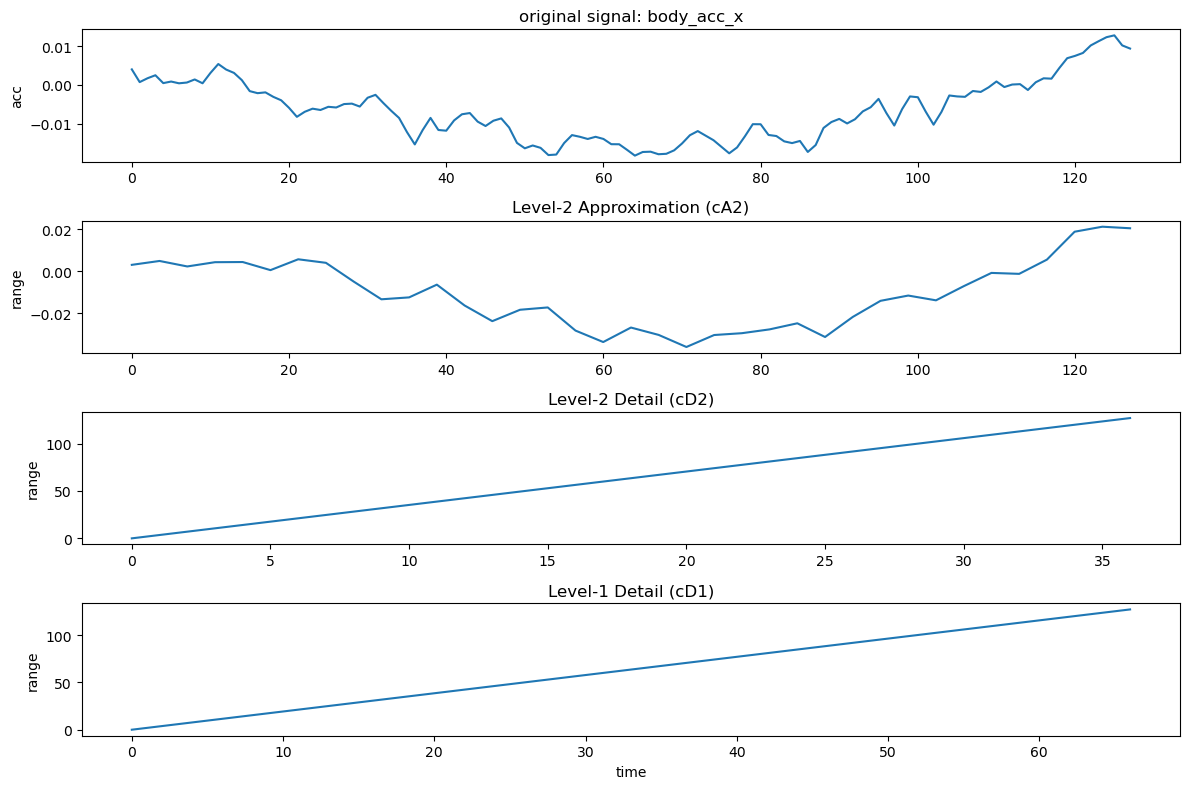

In [20]:
import pywt
import matplotlib.pyplot as plt

idx = y_train[y_train['activity']=='WALKING'].index[0]
sig = signals['body_acc_x'].iloc[idx].values

wavelet = 'db4'
level = 2
coeffs = pywt.wavedec(sig, wavelet=wavelet, level=level)
cA2, cD2, cD1 = coeffs

t = np.arange(len(sig))
tA2 = np.linspace(0, 127, len(cA2))
tD2 = np.linspace(0, 127, len(cD2))
tD1 = np.linspace(0, 127, len(cD1))

plt.figure(figsize=(12, 8))

plt.subplot(4,1,1)
plt.plot(t, sig); plt.title('original signal: body_acc_x'); plt.ylabel('acc')

plt.subplot(4,1,2)
plt.plot(tA2, cA2); plt.title('Level‑2 Approximation (cA2)'); plt.ylabel('range')

plt.subplot(4,1,3)
plt.plot(tD2); plt.title('Level‑2 Detail (cD2)'); plt.ylabel('range')

plt.subplot(4,1,4)
plt.plot(tD1); plt.title('Level‑1 Detail (cD1)'); plt.ylabel('range'); plt.xlabel('time')

plt.tight_layout()
plt.show()

- The first image shows 128 time points of the original acceleration signal.
- The second image cA2 is shorter and only retains the low-frequency trend;
- The third and fourth images cD2 and cD1 show details at different scales, and the high-frequency oscillation is more obvious.

### Energy distribution bar graph

You can also calculate the energy (sum of squares) of each level of coefficients and draw a bar graph to intuitively show the proportion of low frequency vs. high frequency in the signal:

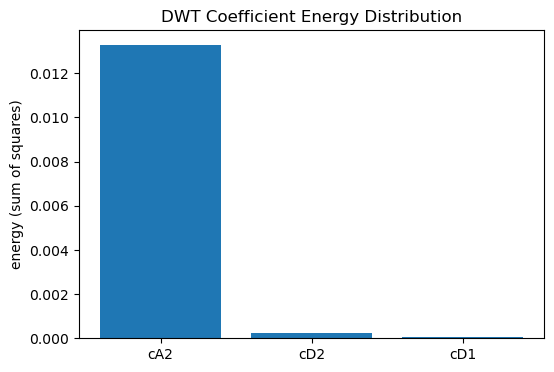

In [21]:
energies = {
    'cA2': np.sum(cA2**2),
    'cD2': np.sum(cD2**2),
    'cD1': np.sum(cD1**2),
}

plt.figure(figsize=(6,4))
plt.bar(energies.keys(), energies.values())
plt.title('DWT Coefficient Energy Distribution')
plt.ylabel('energy (sum of squares)')
plt.show()


Using DWT energy features to distinguish “WALKING” vs “SITTING”

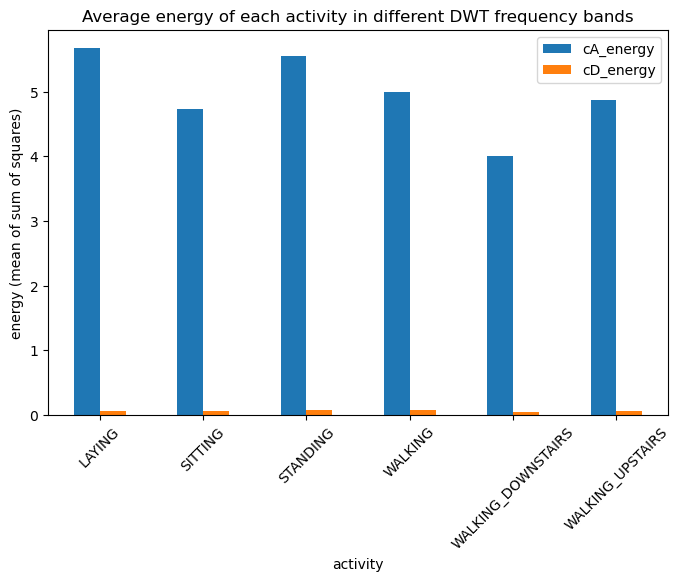

In [22]:
# Count the distribution of each activity in cA2, cD2, cD1 energy
energy_cols = ['cA_energy','cD_energy']
df_plot = df_dwt.groupby('activity')[energy_cols].mean().reset_index()

df_plot.set_index('activity').plot(kind='bar', figsize=(8,5))
plt.title('Average energy of each activity in different DWT frequency bands')
plt.ylabel('energy (mean of sum of squares)')
plt.xticks(rotation=45)
plt.show()


From the figure, we can see that the energy of WALKING in a certain frequency band (such as cD1) is much higher than that of SITTING, which means that the frequency band feature is particularly effective in distinguishing these two types of actions and can be specially retained in subsequent modeling.

# Baseline Classification Model

## Random Forest Model

Accuracy: 0.6172671651937458
                    precision    recall  f1-score   support

            LAYING       0.54      0.74      0.62       276
           SITTING       0.65      0.53      0.58       274
          STANDING       0.67      0.72      0.69       285
           WALKING       0.64      0.59      0.62       237
WALKING_DOWNSTAIRS       0.59      0.46      0.52       190
  WALKING_UPSTAIRS       0.65      0.59      0.62       209

          accuracy                           0.62      1471
         macro avg       0.62      0.61      0.61      1471
      weighted avg       0.62      0.62      0.61      1471



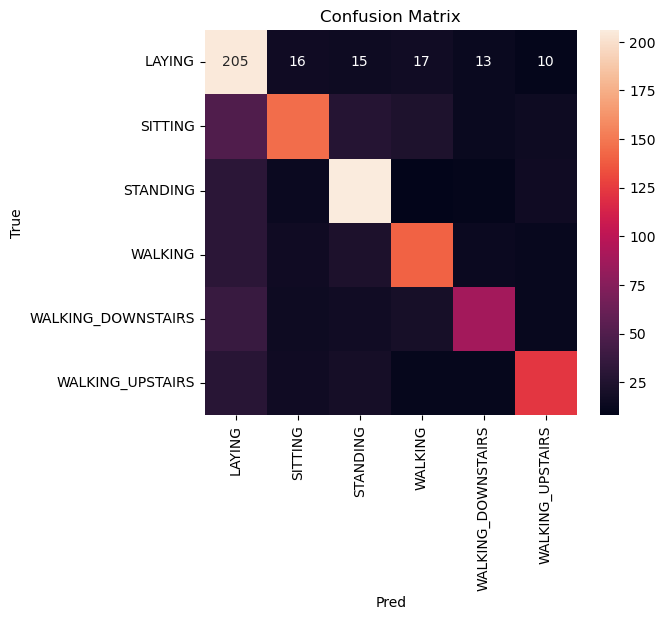

In [23]:
# 5.1.1 Divide the data set
X_tr, X_val, y_tr, y_val = train_test_split(X_pca, y_train['activity'], test_size=0.2, random_state=42)
# 5.1.2 Training Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr, y_tr)
# 5.1.3 Evaluation
y_pred = clf.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Pred'); plt.show()